# Chapter 9: Difference-in-Differences
## Causal Inference: The Mixtape → CausalPy

**Mixtape chapter**: [Difference-in-Differences](https://mixtape.scunning.com/09-difference_in_differences)

**CausalPy method**: `DifferenceInDifferences`

---

### Overview

Difference-in-Differences (DiD) is one of the most widely used identification strategies in applied economics. It compares the change in outcomes over time between a treatment group and a control group, under the assumption that both groups would have followed parallel trends in the absence of treatment.

This notebook covers:

1. **Castle Doctrine** — Effect of "Stand Your Ground" laws on homicide rates
2. **Abortion Legalization** — Effect of early abortion access on gonorrhea rates

### What we'll cover

1. Data exploration and parallel trends visualization
2. Simple 2×2 DiD estimation with CausalPy
3. Interpretation of the Average Treatment Effect on the Treated (ATT)
4. Comparison to Mixtape results

### Important Note on Staggered DiD

The Mixtape examples use **staggered adoption** designs where different units receive treatment at different times. CausalPy's current `DifferenceInDifferences` implementation is designed for the **simple 2×2 case** (one treated group, one control group, pre and post periods).

For staggered DiD, see:
- CausalPy PR #621 (staggered DiD support)
- Recent literature on issues with TWFE in staggered settings (Goodman-Bacon, Callaway & Sant'Anna, Sun & Abraham)

In this notebook, we adapt the examples to work with CausalPy's 2×2 framework.

### Mixtape files implemented

| File | Description | Status |
|------|-------------|--------|
| `castle_1.py` | Castle doctrine - basic DiD | ✅ |
| `castle_2.py` | Castle doctrine - event study | ⏭️ (staggered) |
| `castle_3.py` | Castle doctrine - event study plot | ⏭️ (staggered) |
| `castle_4.py` | Castle doctrine - alternative plot | ⏭️ (staggered) |
| `castle_5.py` | Castle doctrine - robustness | ⏭️ (empty) |
| `abortion_dd.py` | Abortion legalization DiD | ✅ |
| `abortion_dd2.py` | Abortion DiD variations | ✅ |


## Setup


In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import causalpy as cp

# Add the src directory to path for our data utilities
import sys

sys.path.insert(0, "../src")
from mixtape_causalpy import load_castle, load_abortion

%matplotlib inline


---

## Example 1: Castle Doctrine and Homicide Rates

The Castle Doctrine (also known as "Stand Your Ground" laws) expands the legal right to use deadly force in self-defense. The Mixtape examines whether these laws increased homicide rates.

**Key details:**
- **Outcome**: Log homicide rate (`l_homicide`)
- **Treatment**: Adoption of Castle Doctrine (`post` = 1 after adoption)
- **Units**: U.S. states
- **Time period**: 2000-2010

### Adapting to 2×2 DiD

Since CausalPy uses a 2×2 framework, we'll:
1. Select states that adopted in 2006 (the largest cohort) as the **treated group**
2. Use never-treated states as the **control group**
3. Compare pre-2006 to post-2006 periods


In [2]:
# Load the data
castle = load_castle()
print(f"Dataset shape: {castle.shape}")
print(f"\nYears: {sorted(castle['year'].unique())}")
print(f"\nStates: {castle['state'].nunique()}")


Dataset shape: (550, 185)

Years: [np.int16(2000), np.int16(2001), np.int16(2002), np.int16(2003), np.int16(2004), np.int16(2005), np.int16(2006), np.int16(2007), np.int16(2008), np.int16(2009), np.int16(2010)]

States: 50


In [3]:
# Examine treatment timing
treatment_dates = castle.groupby("state")["treatment_date"].first()
print("Treatment adoption by year:")
print(treatment_dates.value_counts().sort_index())

# Identify never-treated states
never_treated = castle.groupby("state")["post"].max()
never_treated_states = never_treated[never_treated == 0].index.tolist()
print(f"\nNever-treated states: {len(never_treated_states)}")

# Identify states that adopted in 2006
adopted_2006 = treatment_dates[treatment_dates == 2006].index.tolist()
print(f"States adopting in 2006: {len(adopted_2006)}")
print(adopted_2006)


Treatment adoption by year:
treatment_date
2005.0     3
2006.0    11
2007.0     4
2008.0     2
2009.0     1
Name: count, dtype: int64

Never-treated states: 29
States adopting in 2006: 11
['Alabama', 'Georgia', 'Indiana', 'Kansas', 'Kentucky', 'Louisiana', 'Michigan', 'Mississippi', 'Oklahoma', 'South Carolina', 'South Dakota']


In [4]:
# Create simplified 2x2 DiD dataset
# Treated: states that adopted in 2006
# Control: never-treated states

# Filter to our groups
castle_2x2 = castle[castle["state"].isin(adopted_2006 + never_treated_states)].copy()

# Create group indicator (1 = treated, 0 = control)
castle_2x2["group"] = castle_2x2["state"].isin(adopted_2006).astype(int)

# Create post_treatment indicator (1 = 2006 or later)
castle_2x2["post_treatment"] = (castle_2x2["year"] >= 2006).astype(int)

# Create unit identifier (required by CausalPy)
castle_2x2["unit"] = castle_2x2["state"]

print(f"2x2 dataset shape: {castle_2x2.shape}")
print(f"\nGroup distribution:")
print(castle_2x2.groupby(["group", "post_treatment"]).size().unstack())


2x2 dataset shape: (440, 188)

Group distribution:
post_treatment    0    1
group                   
0               174  145
1                66   55


### Visualize Parallel Trends

Before running DiD, we should check whether treated and control groups followed similar trends pre-treatment. This is the key identifying assumption.


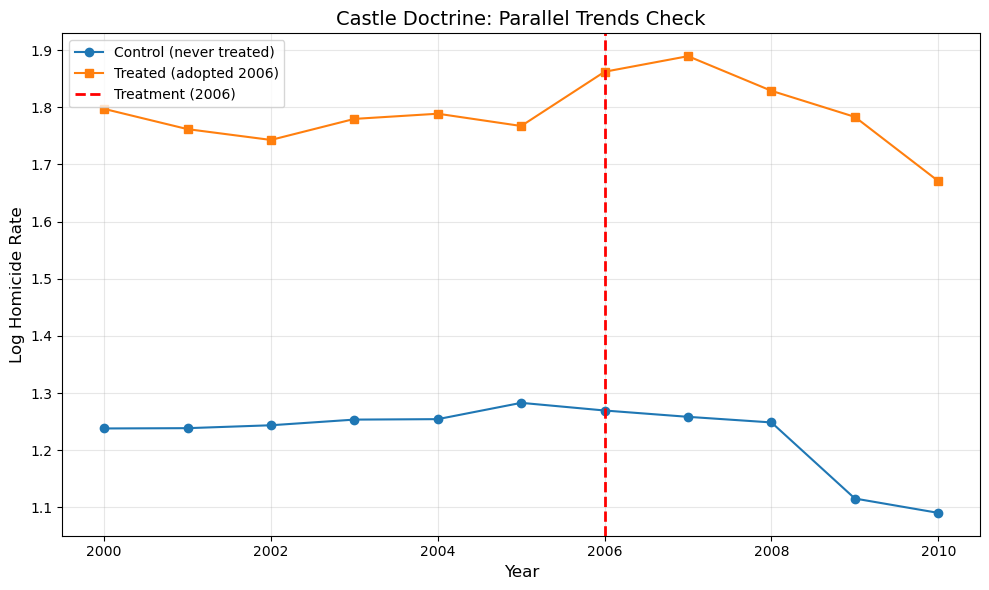

In [5]:
# Plot average outcomes by group over time
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate group means by year
group_means = castle_2x2.groupby(["year", "group"])["l_homicide"].mean().unstack()

# Plot
ax.plot(
    group_means.index, group_means[0], "o-", label="Control (never treated)", color="C0"
)
ax.plot(
    group_means.index, group_means[1], "s-", label="Treated (adopted 2006)", color="C1"
)

# Add vertical line at treatment
ax.axvline(x=2006, color="red", linestyle="--", linewidth=2, label="Treatment (2006)")

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Log Homicide Rate", fontsize=12)
ax.set_title("Castle Doctrine: Parallel Trends Check", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### CausalPy Difference-in-Differences Estimation

Now we'll estimate the DiD effect using CausalPy's `DifferenceInDifferences` class.


In [6]:
# For CausalPy DiD, we need a simpler time structure
# Aggregate to pre/post periods
castle_did = castle_2x2.copy()

# Convert to pre (0) and post (1) time periods
castle_did["t"] = castle_did["post_treatment"].astype(float)

# Aggregate by state and period
castle_agg = (
    castle_did.groupby(["unit", "group", "t", "post_treatment"])
    .agg({"l_homicide": "mean"})
    .reset_index()
)

# Rename outcome
castle_agg = castle_agg.rename(columns={"l_homicide": "y"})

print("Aggregated data for DiD:")
print(castle_agg.head(10))
print(f"\nShape: {castle_agg.shape}")


Aggregated data for DiD:
          unit  group    t  post_treatment         y
0      Alabama      1  0.0               0  1.988068
1      Alabama      1  1.0               1  1.991113
2     Arkansas      0  0.0               0  1.837906
3     Arkansas      0  1.0               1  1.828874
4   California      0  0.0               0  1.913331
5   California      0  1.0               1  1.760559
6     Colorado      0  0.0               0  1.352683
7     Colorado      0  1.0               1  1.139777
8  Connecticut      0  0.0               0  1.095385
9  Connecticut      0  1.0               1  1.254133

Shape: (80, 5)


In [7]:
# Run CausalPy DiD
sample_kwargs = {
    "tune": 1000,
    "draws": 1000,
    "chains": 2,
    "cores": 1,  # Single core for macOS Jupyter compatibility
    "target_accept": 0.95,
    "progressbar": True,
}

castle_result = cp.DifferenceInDifferences(
    castle_agg,
    formula="y ~ 1 + group * post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [8]:
# View the results
castle_result.summary()


===========================Difference in Differences============================
Formula: y ~ 1 + group * post_treatment

Results:
Causal impact = 0.10$CI_{94\%}$[-0.42, 0.63]
Model coefficients:
    Intercept             1.3, 94% HDI [1.1, 1.4]
    group                 0.52, 94% HDI [0.13, 0.89]
    post_treatment        -0.06, 94% HDI [-0.32, 0.21]
    group:post_treatment  0.1, 94% HDI [-0.42, 0.63]
    y_hat_sigma           0.54, 94% HDI [0.47, 0.64]


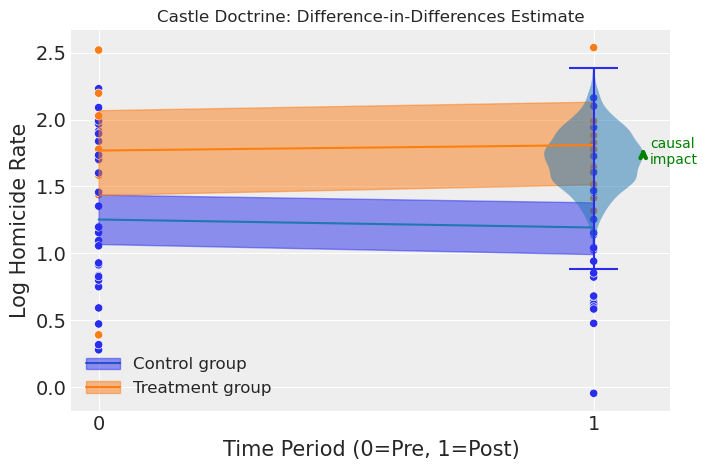

In [9]:
# Plot the DiD result
fig, ax = castle_result.plot()
ax.set_xlabel("Time Period (0=Pre, 1=Post)")
ax.set_ylabel("Log Homicide Rate")
ax.set_title("Castle Doctrine: Difference-in-Differences Estimate")
plt.tight_layout()
plt.show()


### Interpretation

The **causal impact** represents the Average Treatment Effect on the Treated (ATT) — the estimated change in log homicide rates attributable to Castle Doctrine adoption.

**Key findings:**
- The coefficient on `group:post_treatment` is the DiD estimate
- CausalPy provides Bayesian credible intervals for uncertainty quantification
- Compare this to the Mixtape's result from `castle_1.py` which uses weighted least squares with clustered standard errors


---

## Example 2: Abortion Legalization and Gonorrhea Rates

This example examines whether early access to legal abortion (in states that legalized before Roe v. Wade) affected health outcomes, using gonorrhea rates as a proxy.

**Key details:**
- **Outcome**: Log gonorrhea rate (`lnr`)
- **Treatment**: Early abortion legalization (`repeal` = 1 for early-legalizing states)
- **Units**: U.S. states × age cohorts
- **Time period**: 1985-2000


In [10]:
# Load the data
abortion = load_abortion()
print(f"Dataset shape: {abortion.shape}")

# Filter to non-missing outcome
abortion = abortion[~pd.isnull(abortion["lnr"])].copy()
print(f"After dropping missing lnr: {abortion.shape}")


Dataset shape: (19584, 39)
After dropping missing lnr: (17921, 39)


In [11]:
# Key columns
print("Key columns:")
print(abortion[["fip", "year", "repeal", "lnr", "bf15"]].describe())


Key columns:
                fip          year        repeal           lnr          bf15
count  17921.000000  17921.000000  17921.000000  17921.000000  17921.000000
mean      28.587803   1992.526367      0.103454      5.284549      0.041125
std       15.700468      4.605533      0.304559      2.129756      0.198585
min        1.000000   1985.000000      0.000000     -1.791759      0.000000
25%       16.000000   1989.000000      0.000000      3.538057      0.000000
50%       28.000000   1993.000000      0.000000      5.239628      0.000000
75%       41.000000   1997.000000      0.000000      7.124478      0.000000
max       56.000000   2000.000000      1.000000     10.006608      1.000000


In [12]:
# For DiD, focus on the bf15 cohort (as in abortion_dd.py)
# bf15 = 1 indicates cohorts born after 1973 (affected by abortion legalization)
abortion_bf15 = abortion[abortion["bf15"] == 1].copy()
print(f"bf15 cohort shape: {abortion_bf15.shape}")

# Check repeal status
print(
    f"\nRepeal states: {abortion_bf15['repeal'].sum() / len(abortion_bf15) * 100:.1f}%"
)


bf15 cohort shape: (737, 39)

Repeal states: 10.9%


In [13]:
# Prepare data for CausalPy DiD
# We'll create a simpler 2x2 by using 1985-1992 vs 1993-2000

abortion_did = abortion_bf15.copy()

# Treatment group (repeal states)
abortion_did["group"] = abortion_did["repeal"].astype(int)

# Post-treatment (1993 onwards - roughly when effects would manifest)
abortion_did["post_treatment"] = (abortion_did["year"] >= 1993).astype(int)

# Create unit identifier
abortion_did["unit"] = abortion_did["fip"].astype(int).astype(str)

# Time variable
abortion_did["t"] = abortion_did["post_treatment"].astype(float)

print(f"DiD dataset shape: {abortion_did.shape}")
print(f"\nGroup × Post distribution:")
print(abortion_did.groupby(["group", "post_treatment"]).size().unstack())


DiD dataset shape: (737, 42)

Group × Post distribution:
post_treatment    0    1
group                   
0               320  337
1                40   40


In [14]:
# Aggregate by state and period for cleaner DiD
abortion_agg = (
    abortion_did.groupby(["unit", "group", "t", "post_treatment"])
    .agg({"lnr": "mean"})
    .reset_index()
)

abortion_agg = abortion_agg.rename(columns={"lnr": "y"})

print("Aggregated data:")
print(abortion_agg.head(10))
print(f"\nShape: {abortion_agg.shape}")


Aggregated data:
  unit  group    t  post_treatment         y
0    1      0  0.0               0  8.655707
1    1      0  1.0               1  8.102376
2   10      0  0.0               0  8.857288
3   10      0  1.0               1  8.505108
4   11      0  0.0               0  8.838610
5   11      0  1.0               1  8.474384
6   12      0  0.0               0  8.603951
7   12      0  1.0               1  7.899845
8   13      0  0.0               0  8.730507
9   13      0  1.0               1  7.656137

Shape: (102, 5)


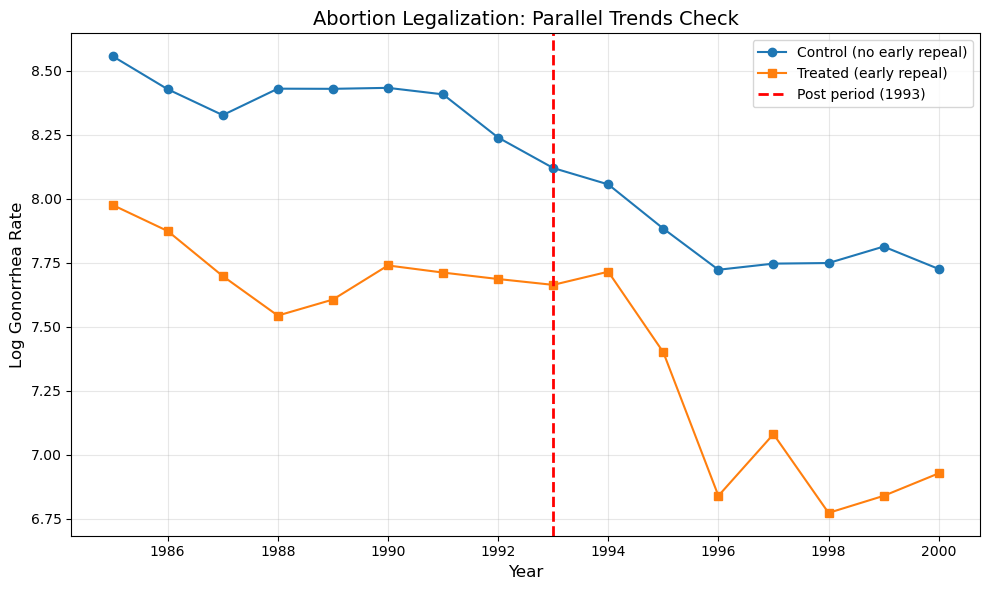

In [15]:
# Visualize parallel trends
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate group means by year
yearly_means = abortion_did.groupby(["year", "group"])["lnr"].mean().unstack()

# Plot
ax.plot(
    yearly_means.index,
    yearly_means[0],
    "o-",
    label="Control (no early repeal)",
    color="C0",
)
ax.plot(
    yearly_means.index,
    yearly_means[1],
    "s-",
    label="Treated (early repeal)",
    color="C1",
)

# Add vertical line at "treatment" time
ax.axvline(x=1993, color="red", linestyle="--", linewidth=2, label="Post period (1993)")

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Log Gonorrhea Rate", fontsize=12)
ax.set_title("Abortion Legalization: Parallel Trends Check", fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [16]:
# Run CausalPy DiD
abortion_result = cp.DifferenceInDifferences(
    abortion_agg,
    formula="y ~ 1 + group * post_treatment",
    time_variable_name="t",
    group_variable_name="group",
    model=cp.pymc_models.LinearRegression(sample_kwargs=sample_kwargs),
)


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, y_hat_sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [17]:
# View the results
abortion_result.summary()


===========================Difference in Differences============================
Formula: y ~ 1 + group * post_treatment

Results:
Causal impact = -0.04$CI_{94\%}$[-0.91, 0.84]
Model coefficients:
    Intercept             8.3, 94% HDI [8.1, 8.5]
    group                 -0.55, 94% HDI [-1.2, 0.031]
    post_treatment        -0.54, 94% HDI [-0.81, -0.27]
    group:post_treatment  -0.041, 94% HDI [-0.91, 0.84]
    y_hat_sigma           0.69, 94% HDI [0.61, 0.8]


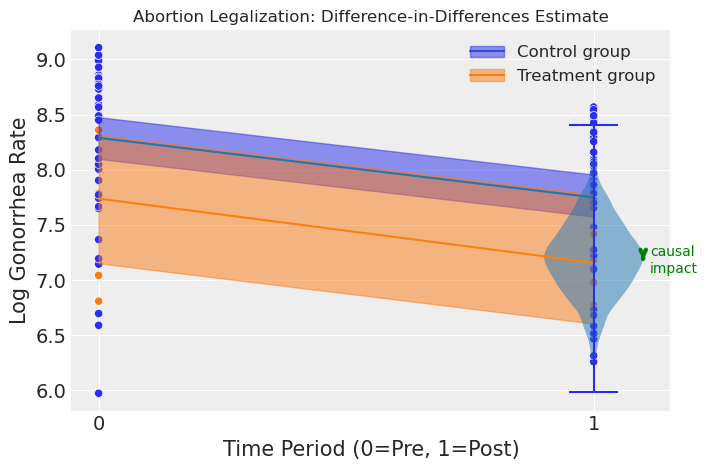

In [18]:
# Plot the DiD result
fig, ax = abortion_result.plot()
ax.set_xlabel("Time Period (0=Pre, 1=Post)")
ax.set_ylabel("Log Gonorrhea Rate")
ax.set_title("Abortion Legalization: Difference-in-Differences Estimate")
plt.tight_layout()
plt.show()


---

## Comparison to Mixtape Results

### Key Differences

| Aspect | Mixtape | This Notebook |
|--------|---------|---------------|
| Estimation | Weighted OLS with clustered SEs | Bayesian linear regression |
| Treatment timing | Staggered (TWFE) | Simplified 2×2 |
| Uncertainty | Frequentist confidence intervals | Bayesian credible intervals |
| Covariates | Many controls included | None (simple specification) |

### Why the Results May Differ

1. **Aggregation**: We simplified the staggered design to 2×2, which changes the effective sample
2. **No covariates**: Mixtape includes many control variables (demographics, spending, etc.)
3. **No weighting**: Mixtape uses population weights
4. **Bayesian estimation**: Different uncertainty quantification approach

### Event Study (TODO)

The Mixtape's `castle_2.py` through `castle_4.py` implement event study designs that show dynamic treatment effects over time. This requires:
- Lead and lag indicators relative to treatment
- Plotting coefficients with confidence/credible intervals

See CausalPy PR #584 for event study support.


---

## TODO: Event Study Design

> **Not yet implemented**: Event study designs require lead/lag indicators around treatment timing, which is related to staggered DiD.

**Mixtape reference**: `castle_2.py`, `castle_3.py`, `castle_4.py`

**CausalPy tracking**:
- Event study plots: PR #584
- Staggered DiD: PR #621

**When to revisit**: Once CausalPy adds staggered DiD or event study support.


---

## TODO: Triple Differences (DDD)

> **Not yet implemented**: Triple differences adds a third differencing dimension and is not currently supported by CausalPy.

**Mixtape reference**: `abortion_ddd.py`, `abortion_ddd2.py`

**CausalPy tracking**: No current issue/PR for DDD

**When to revisit**: Would need a new experiment class in CausalPy.


---

## Summary

In this notebook, we demonstrated CausalPy's `DifferenceInDifferences` experiment using two classic examples from the Mixtape:

1. **Castle Doctrine**: Estimated the effect of Stand Your Ground laws on homicide rates by comparing states that adopted in 2006 to never-treated states

2. **Abortion Legalization**: Estimated the effect of early abortion access on gonorrhea rates

**Key takeaways:**

- CausalPy's DiD is designed for the classic 2×2 case
- For staggered designs (common in applied work), adaptations are needed
- Bayesian estimation provides intuitive uncertainty quantification
- The `plot()` method visualizes the counterfactual and causal impact

**Next steps:**
- When CausalPy adds staggered DiD support, return to implement the full event study analyses
- Consider adding covariates to the formula for richer specifications


---

## References

- **Mixtape chapter**: https://mixtape.scunning.com/09-difference_in_differences
- **CausalPy docs**: https://causalpy.readthedocs.io
- **Original papers**:
  - Cheng, C., & Hoekstra, M. (2013). "Does Strengthening Self-Defense Law Deter Crime or Escalate Violence?"
  - Donohue, J., & Levitt, S. (2001). "The Impact of Legalized Abortion on Crime"
- **Modern DiD literature**:
  - Goodman-Bacon, A. (2021). "Difference-in-Differences with Variation in Treatment Timing"
  - Callaway, B., & Sant'Anna, P. (2021). "Difference-in-Differences with Multiple Time Periods"
